In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *

In [2]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Sei_feature_0529_norm.csv')

In [3]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [4]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)

data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'

data_split_dict['high'] = MPRA_df[cell_types].mean(axis=1) > 1


# MPRA_df['std'] = MPRA_df[cell_types].std(axis=1, skipna=True)
# threshold = np.percentile(MPRA_df['std'].dropna(), 95)
# data_split_dict['diff'] = (MPRA_df['std'] > threshold)
# data_split_dict['const'] = ~data_split_dict['diff']





# 计算每条序列在不同细胞类型中的最大值和最小值之差
MPRA_df['range'] = MPRA_df[cell_types].max(axis=1, skipna=True) - MPRA_df[cell_types].min(axis=1, skipna=True)
# 计算 range 的第95百分位
threshold = np.percentile(MPRA_df['range'].dropna(), 95)
# 前5%的高差值序列为 diff，其余为 const
data_split_dict['diff'] = MPRA_df['range'] > threshold
data_split_dict['const'] = ~data_split_dict['diff']






# for cell_type in cell_types:
#     # 计算该细胞类型与所有细胞类型平均值的偏差
#     deviation = (MPRA_df[cell_type] - MPRA_df[['K562', 'HepG2', 'SK-N-SH']].mean(axis=1)) # 只考虑特异性激活的5%
#     # plt.figure()
#     # sns.histplot(deviation)
#     threshold = np.percentile(deviation.dropna(), 95)
#     data_split_dict[f'{cell_type}_specific'] = (deviation >= threshold) & (MPRA_df[cell_type] > 1.0)



for cell_type in cell_types:
    # 计算该细胞类型与所有细胞类型平均值的偏差
    deviation = (MPRA_df[cell_type] - MPRA_df[['K562', 'HepG2', 'SK-N-SH']].mean(axis=1)).abs()
    # plt.figure()
    # sns.histplot(deviation)
    threshold = np.percentile(deviation.dropna(), 95)
    data_split_dict[f'{cell_type}_specific'] = (deviation >= threshold)





for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
chrom 760679
designed 0
train 631073
valid 70952
test 58654
ref 389266
alt 371413
high 79000
diff 38034
const 722645
K562_specific 38034
HepG2_specific 38034
SK-N-SH_specific 38034
HCT116_specific 22406
A549_specific 15975


In [5]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

In [6]:
# cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116',]
# assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']
# data_splits = ['total', 'train', 'valid', 'test']


# # train
# data_split = 'train'

# train_cell_types = ['K562', 'HepG2', 'SK-N-SH']
# valid_cell_types = ['HCT116']


# X_train = []
# y_train = []
# for cell_type in train_cell_types:
#     condition = data_split_dict[data_split]
#     X_columns = [f'{cell_type}_{assay}' for assay in assays]
#     y_column = cell_type
    
#     X_train.append(MPRA_df.loc[condition, X_columns])
#     y_train.append(MPRA_df.loc[condition, y_column])

# X_train = np.concatenate(X_train, axis=0)
# y_train = np.concatenate(y_train, axis=0)

# model = LinearRegression()
# # model = MLPRegressor(hidden_layer_sizes=100, alpha=1e-3)
# model.fit(X_train, y_train)


# # valid
# r_array = pd.DataFrame(dtype=float)

# for cell_type in cell_types:
#     for data_split in data_splits:
#         condition = data_split_dict[data_split]
#         X_columns = [f'{cell_type}_{assay}' for assay in assays]
#         y_column = cell_type

#         X_valid = np.array(MPRA_df.loc[condition, X_columns])
#         y_valid = np.array(MPRA_df.loc[condition, y_column])

#         y_pred = model.predict(X_valid)

#         r = pearson(y_valid, y_pred)[0]
#         r_array.loc[cell_type, data_split] = r

# print(r_array)

In [7]:
# cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116',]
# assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']
# data_splits = ['total', 'train', 'valid', 'test']


# # train
# data_split = 'train'
# train_cell_types = ['K562', 'HepG2', 'SK-N-SH']


# X_train = []
# y_train = []
# for cell_type in train_cell_types:
#     condition = data_split_dict[data_split]
#     X_columns = [f'{cell_type}_{assay}' for assay in assays]
#     y_column = cell_type
    
#     X_train.append(MPRA_df.loc[condition, X_columns])
#     y_train.append(MPRA_df.loc[condition, y_column])

# X_train = np.concatenate(X_train, axis=0)
# y_train = np.concatenate(y_train, axis=0)

# print(X_train.shape, y_train.shape)
# # model = LinearRegression()
# model = MLPRegressor(hidden_layer_sizes=100, alpha=1e-3)
# model.fit(X_train, y_train)


# # valid
# r_array = pd.DataFrame(dtype=float)

# for cell_type in cell_types:
#     for data_split in data_splits:
#         condition = data_split_dict[data_split]
#         X_columns = [f'{cell_type}_{assay}' for assay in assays]
#         y_column = cell_type

#         X_valid = np.array(MPRA_df.loc[condition, X_columns])
#         y_valid = np.array(MPRA_df.loc[condition, y_column])

#         y_pred = model.predict(X_valid)

#         r = pearson(y_valid, y_pred)[0]
#         r_array.loc[cell_type, data_split] = r

# print(r_array)

In [8]:
# hidden = 100
#          total  train  valid  test
# K562     0.636  0.639  0.636 0.606
# HepG2    0.590  0.593  0.582 0.562
# SK-N-SH  0.574  0.576  0.568 0.549
# HCT116   0.616  0.617  0.622 0.585

# train on K562, HepG2, SK-N-SH or 3 cell types

In [10]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']
data_splits = ['train', 'test', 'test+diff']


for train_cell_types in [['K562'], ['HepG2'], ['SK-N-SH'], ['K562', 'HepG2'], ['K562', 'HepG2', 'SK-N-SH']]:
    # train
    train_data_split = 'train'
    # train_cell_types = ['K562']

    X_train = []
    y_train = []
    for cell_type in train_cell_types:
        condition = data_split_dict[train_data_split]
        X_columns = [f'{cell_type}_{assay}' for assay in assays]
        y_column = cell_type
        
        X_train.append(MPRA_df.loc[condition, X_columns])
        y_train.append(MPRA_df.loc[condition, y_column])

    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    print(X_train.shape, y_train.shape)


    model = LinearRegression()
    # model = MLPRegressor(hidden_layer_sizes=100, alpha=1e-3)
    model.fit(X_train, y_train)


    # valid
    pearson_df = pd.DataFrame(dtype=float)

    for cell_type in cell_types:
        for data_split in data_splits:
            condition = data_split_dict[data_split]
            X_columns = [f'{cell_type}_{assay}' for assay in assays]
            y_column = cell_type

            X_valid = np.array(MPRA_df.loc[condition, X_columns])
            y_valid = np.array(MPRA_df.loc[condition, y_column])

            y_pred = model.predict(X_valid)

            r = pearson(y_valid, y_pred)[0]
            pearson_df.loc[cell_type, data_split] = r

    print(f'trained on {train_cell_types}')
    print(f'model architecture: LinearRegression()')
    print(pearson_df)

(631073, 4) (631073,)
trained on ['K562']
model architecture: LinearRegression()
         train  test  test+diff
K562     0.552 0.513      0.591
HepG2    0.500 0.467      0.578
SK-N-SH  0.373 0.329      0.287
HCT116   0.474 0.431      0.477
A549     0.350 0.311      0.377
(631073, 4) (631073,)
trained on ['HepG2']
model architecture: LinearRegression()
         train  test  test+diff
K562     0.523 0.477      0.564
HepG2    0.537 0.503      0.568
SK-N-SH  0.355 0.311      0.250
HCT116   0.495 0.457      0.556
A549     0.373 0.333      0.430
(631073, 4) (631073,)
trained on ['SK-N-SH']
model architecture: LinearRegression()
         train  test  test+diff
K562     0.503 0.481      0.561
HepG2    0.492 0.476      0.619
SK-N-SH  0.521 0.496      0.501
HCT116   0.515 0.500      0.601
A549     0.384 0.362      0.413
(1262146, 4) (1262146,)
trained on ['K562', 'HepG2']
model architecture: LinearRegression()
         train  test  test+diff
K562     0.543 0.499      0.584
HepG2    0.530 0.496 

# select model

In [9]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']
data_splits = ['train', 'test', 'test+diff']


for train_cell_types in [['K562', 'HepG2', 'SK-N-SH']]:
    # train
    train_data_split = 'train'
    # train_cell_types = ['K562']

    X_train = []
    y_train = []
    for cell_type in train_cell_types:
        condition = data_split_dict[train_data_split]
        X_columns = [f'{cell_type}_{assay}' for assay in assays]
        y_column = cell_type
        
        X_train.append(MPRA_df.loc[condition, X_columns])
        y_train.append(MPRA_df.loc[condition, y_column])

    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    print(X_train.shape, y_train.shape)

    for model in ['LR', 'MLP', 'RF', 'GBDT', 'HGBDT']:
        if model == 'LR':
            model = LinearRegression()
        elif model == 'MLP':
            model = MLPRegressor(random_state=0)  # default hidden_layer_sizes=(100,)
        elif model == 'RF':
            model = RandomForestRegressor(random_state=0)
        elif model == 'GBDT':
            model = GradientBoostingRegressor(random_state=0)
        elif model == 'HGBDT':
            model = HistGradientBoostingRegressor(random_state=0)

        model.fit(X_train, y_train)

        # valid
        pearson_df = pd.DataFrame(dtype=float)

        for cell_type in cell_types:
            for data_split in data_splits:
                condition = data_split_dict[data_split]
                X_columns = [f'{cell_type}_{assay}' for assay in assays]
                y_column = cell_type

                X_valid = np.array(MPRA_df.loc[condition, X_columns])
                y_valid = np.array(MPRA_df.loc[condition, y_column])

                y_pred = model.predict(X_valid)

                r = pearson(y_valid, y_pred)[0]
                pearson_df.loc[cell_type, data_split] = r

        print(f'trained on {train_cell_types}')
        print(f'model architecture: {model}')
        print(pearson_df)

(1893219, 4) (1893219,)
trained on ['K562', 'HepG2', 'SK-N-SH']
model architecture: LinearRegression()
         train  test  test+diff
K562     0.526 0.497      0.580
HepG2    0.509 0.487      0.621
SK-N-SH  0.503 0.474      0.470
HCT116   0.522 0.497      0.592
A549     0.391 0.362      0.421
trained on ['K562', 'HepG2', 'SK-N-SH']
model architecture: MLPRegressor(random_state=0)
         train  test  test+diff
K562     0.637 0.603      0.598
HepG2    0.595 0.562      0.586
SK-N-SH  0.578 0.552      0.517
HCT116   0.617 0.583      0.588
A549     0.496 0.453      0.461
trained on ['K562', 'HepG2', 'SK-N-SH']
model architecture: RandomForestRegressor(random_state=0)
         train  test  test+diff
K562     0.970 0.573      0.581
HepG2    0.969 0.533      0.582
SK-N-SH  0.966 0.522      0.503
HCT116   0.586 0.558      0.566
A549     0.461 0.425      0.448
trained on ['K562', 'HepG2', 'SK-N-SH']
model architecture: GradientBoostingRegressor(random_state=0)
         train  test  test+diff


In [25]:
import itertools
pseudo_cell_types = list(itertools.product([0, 1], repeat=4))
pseudo_cell_types

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1)]

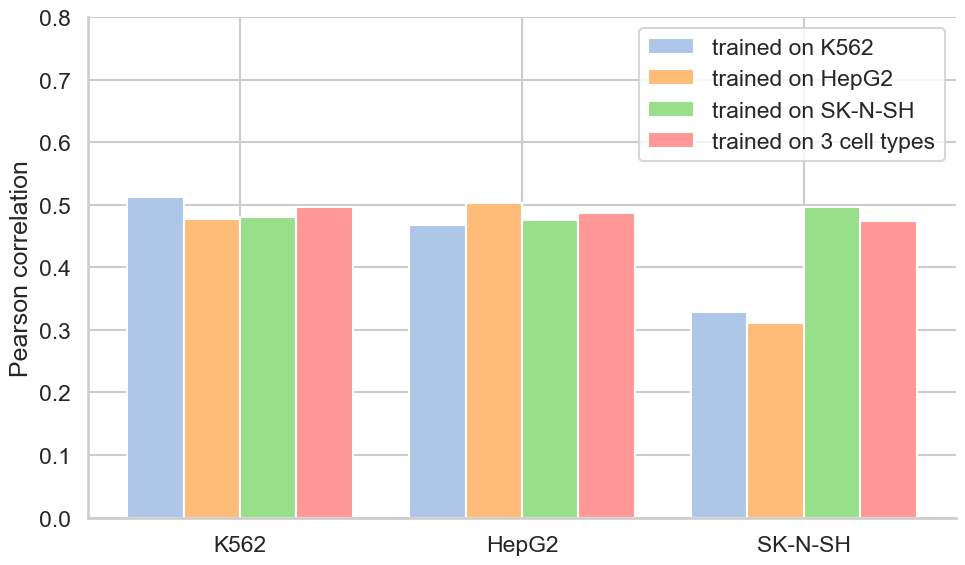

In [63]:
import pandas as pd
sns.set_theme(context='talk', style="whitegrid")
# Create the DataFrame
df = pd.DataFrame(
    data=[
        [0.513, 0.467, 0.329],
        [0.477, 0.503, 0.311],
        [0.481, 0.476, 0.496],
        [0.497, 0.487, 0.474]
    ],
    index=["trained on K562", "trained on HepG2", "trained on SK-N-SH", "trained on 3 cell types"],
    columns=['K562', 'HepG2', 'SK-N-SH']
)

# Setup for plotting
x_pos = np.array([0, 1, 2])
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

for i, label in enumerate(df.index):
    ax.bar(x_pos + (i - 1.5) * width, df.iloc[i], width, label=label, color=tab20_colors[i*2+1], )#edgecolor='none')


# Add labels, legend, and formatting
ax.set_ylim(0, 0.8)
ax.set_ylabel('Pearson correlation')
ax.set_xticks(x_pos)
ax.set_xticklabels(df.columns)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/Gosai_MPRA_epi_based_model_bar.png', dpi=400)
plt.show()